<h1 style="text-align: center;">IOB + LSTM</h1>

In [1]:
# Connect to drive
import os, sys
from google.colab import drive
drive.mount('/content/drive')
colab_path = '/content/notebooks'
os.symlink('/content/drive/My Drive/Colab Notebooks', colab_path)
sys.path.insert(0,colab_path)

Mounted at /content/drive


# LSTM Based on word

## Data preparation

In [ ]:
import pandas as pd

#Import the relevant data
df_clean = pd.read_csv(r"/content/drive/MyDrive/Final Project/Field Project/NER - IOB/POS_lemma_DepPars_noTypo_inplaced.csv")

In [ ]:
from itertools import chain

# Mapping between tokens and their corresponding IDs
def dict_map (data, word_tag):
	token_TO_id = {}
	id_TO_token = {}
	if word_tag == 'word':
		vocab = list(set(data['word'].to_list()))
	else:
		vocab = list(set(data['tag'].to_list()))

	#mapping dictionaries
	id_TO_token = {id:tok for id,tok in enumerate(vocab)}
	token_TO_id = {tok:id for id,tok in enumerate(vocab)}
	return token_TO_id, id_TO_token

In [ ]:
word_TO_id, id_TO_word = dict_map(df_clean, 'word')
tag_TO_id, id_TO_tag = dict_map(df_clean, 'tag')

In [ ]:
#Apply mapping on the data
df_clean['word_id'] = df_clean['word'].map(word_TO_id)
df_clean['tag_id'] = df_clean['tag'].map(tag_TO_id)

In [ ]:
df_clean.head()

,Unnamed: 0,word,tag,Paragraph_place,POS,Lemma,Dependency_pars,word_id,tag_id
0,0,Rydberg,B,A Rydberg 1,PROPN,Rydberg,compound,3437,1
1,1,atomic,I,A Rydberg 1,ADJ,atomic,amod,4562,2
2,2,sensors,I,A Rydberg 1,NOUN,sensor,nsubj,10581,2
3,3,and,I,A Rydberg 1,CCONJ,and,cc,1586,2
4,4,receivers,I,A Rydberg 1,NOUN,receiver,conj,2491,2


In [ ]:
#Group by predefined column as mark and aggregate the columns
df_grouped = df_clean.groupby(['Paragraph_place'], as_index=False)[['word', 'tag', 'POS', 'word_id', 'tag_id']].agg(lambda x: list(x))


In [ ]:
df_grouped

,Paragraph_place,word,tag,POS,word_id,tag_id
0,A Rydberg 1,"[Rydberg, atomic, sensors, and, receivers, hav...","[B, I, I, I, I, I, I, I, I, I, I, I, I, I, I, ...","[PROPN, ADJ, NOUN, CCONJ, NOUN, AUX, VERB, ADJ...","[3437, 4562, 10581, 1586, 2491, 7308, 11273, 5...","[1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
1,A Rydberg 10,"[The, automotive, radar, chip, presented, as, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[DET, ADJ, NOUN, NOUN, VERB, ADP, DET, NOUN, A...","[4438, 8674, 13, 2559, 5737, 11093, 623, 3734,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,A Rydberg 11,"[For, the, demonstration, of, the, benchmarkin...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[ADP, DET, NOUN, ADP, DET, NOUN, NOUN, PUNCT, ...","[10312, 623, 540, 11885, 623, 2231, 3657, 9116...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,A Rydberg 12,"[Next, ,, we, use, the, setup, to, estimate, t...","[O, O, B, I, I, I, I, I, I, I, I, I, I, I, I, ...","[ADV, PUNCT, PRON, VERB, DET, NOUN, ADP, VERB,...","[9944, 9116, 9110, 2341, 623, 3657, 10570, 941...","[0, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
4,A Rydberg 13,"[Consequently, ,, we, demonstrate, that, using...","[O, O, B, I, I, I, I, I, O, I, I, I, I, I, I, ...","[ADV, PUNCT, PRON, VERB, SCONJ, VERB, DET, NOU...","[3867, 9116, 9110, 1633, 2329, 3882, 5160, 365...","[0, 0, 1, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, ..."
...,...,...,...,...,...,...
642,global enviornment 5,"[The, global, health, costs, associated, with,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[DET, ADJ, NOUN, NOUN, VERB, ADP, DET, NOUN, A...","[4438, 3165, 9150, 883, 6875, 9672, 623, 7258,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
643,global enviornment 6,"[Environmental, justice, is, defined, by, the,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[PROPN, NOUN, AUX, VERB, ADP, DET, PROPN, PROP...","[5397, 515, 2400, 6812, 8462, 623, 5700, 5508,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
644,global enviornment 7,"[The, first, step, in, the, global, textile, s...","[B, I, I, I, I, I, I, I, I, I, I, I, O, B, I, ...","[DET, ADJ, NOUN, ADP, DET, ADJ, NOUN, NOUN, NO...","[4438, 10598, 5485, 5232, 623, 3165, 10130, 10...","[1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 2, ..."
645,global enviornment 8,"[Garment, assembly, ,, the, next, step, in, th...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[NOUN, NOUN, PUNCT, DET, ADJ, NOUN, ADP, DET, ...","[4476, 9221, 9116, 623, 2143, 5485, 5232, 623,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
from sklearn.model_selection import train_test_split

#Create Train/Validation/Test set and ensure split point is not in the middle of a sequence
grouped = df_grouped.groupby('Paragraph_place')

sizes = grouped.size().cumsum() #cumulative size

train_size = 0.7 * sizes.iloc[-1]
val_size = 0.2 * train_size
test_size = sizes.iloc[-1] - train_size

#Train, test index based on 'Paragraph_place' column
train_idx = sizes[sizes <= train_size].index
test_idx = sizes[sizes > train_size].index


train_data_with_val = df_grouped[df_grouped['Paragraph_place'].isin(train_idx)]
test_data = df_grouped[df_grouped['Paragraph_place'].isin(test_idx)]

#Validation set
train_sizes = train_data_with_val.groupby('Paragraph_place').size().cumsum()
val_idx = train_sizes[train_sizes <= val_size].index
final_train_idx = train_sizes[train_sizes > val_size].index

val_data = train_data_with_val[train_data_with_val['Paragraph_place'].isin(val_idx)]
train_data = train_data_with_val[train_data_with_val['Paragraph_place'].isin(final_train_idx)]



In [ ]:
print ("Training set rows:", len (train_data))
print ("Valdiation set rows:",len (val_data))
print ("Test set rows:",len (test_data))

Training set rows: 362
Valdiation set rows: 90
Test set rows: 195


In [ ]:
#Maximum Paragh length
Paragh_list = train_data['word_id'].to_list()
max_lenght = max([len(paragh) for paragh in Paragh_list])
print("max Paragraph length is %i" %max_lenght)

max Paragraph length is 978


In [ ]:
#Maximum Tag length
Tag_list = train_data['tag_id'].to_list()
max_lenght_tag = max([len(tag) for tag in Tag_list])
print("max Tag length is %i" %max_lenght_tag)

max Tag length is 978


In [ ]:
#Padding
from tensorflow.keras.preprocessing.sequence import pad_sequences

pad_paraghs = pad_sequences(Paragh_list, maxlen= max_lenght, padding='post', value= word_TO_id['The'])

In [ ]:
# Padding
pad_tags = pad_sequences(Tag_list, maxlen=max_lenght_tag, padding='post', value=tag_TO_id['O'])

# Convert tag to encoding
from tensorflow.keras.utils import to_categorical

#determine number of classes
num_classes = len(tag_TO_id)
pad_tags = to_categorical(pad_tags, num_classes=num_classes)




In [ ]:
#Check the shapes
train_paraghs = pad_paraghs
train_paraghs.shape

(362, 978)

In [ ]:
#Check the shapes
train_tags = pad_tags
train_tags.shape

(362, 978, 3)

## Defining model

In [ ]:
import numpy as np
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import Embedding, LSTM, TimeDistributed, Dense
from tensorflow.keras.utils import plot_model
import tensorflow as tf

In [ ]:
# Network details and specifications
shape = train_paraghs[1].shape
input_dim = len(list(set(df['word'].to_list())))+1
output_dim = 32 #64 led to crash
input_length = max_lenght
output_nodes = len (id_TO_tag)

In [ ]:
import tensorflow
import gc

#Clear Keras
tensorflow.keras.backend.clear_session()
gc.collect()

input_layer  = Input(shape=(978,))
embedding = Embedding(input_dim=input_dim, output_dim=output_dim)(input_layer) #Embedding Layer
Lstm_1 = LSTM(units= output_dim, return_sequences=True )(embedding) #LSTM1
Lstm_2 = LSTM(units= output_dim, return_sequences=True)(Lstm_1) #LSTM2
output = TimeDistributed(Dense(units=output_nodes, activation='softmax'))(Lstm_2)

model = Model(inputs= input_layer, outputs=output)

In [ ]:
model.compile(optimizer= tensorflow.keras.optimizers.RMSprop(1e-3), loss = tensorflow.keras.losses.CategoricalCrossentropy, metrics=['acc'])

In [ ]:
#Validation data
Paragh_list_validation = val_data['word_id'].to_list()

Tag_list_validation = val_data['tag_id'].to_list()


#Padding
from tensorflow.keras.preprocessing.sequence import pad_sequences

pad_paraghs_val = pad_sequences(Paragh_list_validation, maxlen= max_lenght, padding='post', value= word_TO_id['The'])


pad_tag_val = pad_sequences(Tag_list_validation, maxlen=max_lenght_tag, padding='post', value=tag_TO_id['O'])

# Convert tag to encoding
num_classes = len(tag_TO_id)
pad_tag_val = to_categorical(pad_tag_val, num_classes=num_classes)


In [ ]:
val_paraghs = pad_paraghs_val
val_tags = pad_tag_val

In [ ]:
#Check the shapes
print('Train paragraph shape:', train_paraghs.shape)
print('Train tags shape:', train_tags.shape)
print('Validation paragraph shape:', val_paraghs.shape)
print('Validation tags shape:', val_tags.shape)


Train paragraph shape: (362, 978)
Train tags shape: (362, 978, 3)
Validation paragraph shape: (90, 978)
Validation tags shape: (90, 978, 3)


In [ ]:
# Train the  model
history = model.fit(train_paraghs, train_tags, epochs=10,
                validation_data=(val_paraghs, val_tags), batch_size = 8, verbose=1
                #callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=10)]
                    )


Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - acc: 0.8616 - loss: 0.4023 - val_acc: 0.9404 - val_loss: 0.1354
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - acc: 0.9473 - loss: 0.1233 - val_acc: 0.9404 - val_loss: 0.1273
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - acc: 0.9482 - loss: 0.1204 - val_acc: 0.9403 - val_loss: 0.1308
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - acc: 0.9403 - loss: 0.1315 - val_acc: 0.9404 - val_loss: 0.1321
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - acc: 0.9443 - loss: 0.1227 - val_acc: 0.9404 - val_loss: 0.1255
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - acc: 0.9464 - loss: 0.1154 - val_acc: 0.9404 - val_loss: 0.1261
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - acc: 0.9408 - loss: 0.1268 - val_acc: 0.9404 - val_loss: 0.1249
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - acc: 0.9508 - loss: 0.1068 - val_acc: 0.9404 - val_loss: 0.1442
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - acc: 0.9473 - loss:

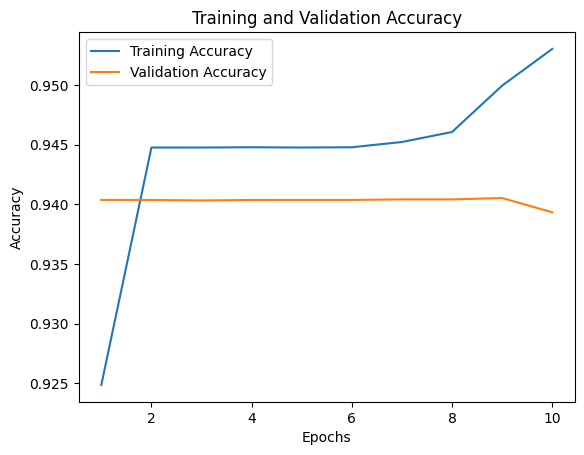

In [ ]:
import matplotlib.pyplot as plt

Acc = history.history["acc"]
val_Acc = history.history["val_acc"]

# Plotting
epochs = range(1, len(Acc) + 1)

plt.plot(epochs, Acc, label="Training Accuracy")
plt.plot(epochs, val_Acc, label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

The validation set accuracy curve is flat which is a sign for overfitting.

# LSTM Based on Lemma

## Data preparation

In [ ]:
import pandas as pd
df_clean = pd.read_csv(r"/content/drive/MyDrive/Final Project/Field Project/NER - IOB/POS_lemma_DepPars_noTypo_inplaced.csv")

In [ ]:
from itertools import chain

# Mapping between tokens and their corresponding IDs
def dict_map (data, word_tag):
	token_TO_id = {}
	id_TO_token = {}
	if word_tag == 'Lemma':
		vocab = list(set(data['Lemma'].to_list()))
	else:
		vocab = list(set(data['tag'].to_list()))

	#mapping dictionaries
	id_TO_token = {id:tok for id,tok in enumerate(vocab)}
	token_TO_id = {tok:id for id,tok in enumerate(vocab)}
	return token_TO_id, id_TO_token

In [ ]:
lemma_TO_id, id_TO_lemma = dict_map(df_clean, 'Lemma')
tag_TO_id, id_TO_tag = dict_map(df_clean, 'tag')

In [ ]:
#Apply mapping on the data
df_clean['Lemma_id'] = df_clean['Lemma'].map(lemma_TO_id)
df_clean['tag_id'] = df_clean['tag'].map(tag_TO_id)

In [ ]:
df_clean.head()

,Unnamed: 0,word,tag,Paragraph_place,POS,Lemma,Dependency_pars,Lemma_id,tag_id
0,0,Rydberg,B,A Rydberg 1,PROPN,Rydberg,compound,6803,0
1,1,atomic,I,A Rydberg 1,ADJ,atomic,amod,5577,2
2,2,sensors,I,A Rydberg 1,NOUN,sensor,nsubj,6949,2
3,3,and,I,A Rydberg 1,CCONJ,and,cc,5738,2
4,4,receivers,I,A Rydberg 1,NOUN,receiver,conj,5875,2


In [ ]:
#Group by predefined column as mark and aggregate the columns
df_grouped = df_clean.groupby(['Paragraph_place'], as_index=False)[['Lemma', 'tag', 'POS', 'Dependency_pars', 'Lemma_id', 'tag_id']].agg(lambda x: list(x))

In [ ]:
from sklearn.model_selection import train_test_split

grouped = df_grouped.groupby('Paragraph_place')

sizes = grouped.size().cumsum() #cumulative size

train_size = 0.7 * sizes.iloc[-1]
val_size = 0.2 * train_size
test_size = sizes.iloc[-1] - train_size

#Train, test index based on 'Paragraph_place' column
train_idx = sizes[sizes <= train_size].index
test_idx = sizes[sizes > train_size].index


train_data_with_val = df_grouped[df_grouped['Paragraph_place'].isin(train_idx)]
test_data = df_grouped[df_grouped['Paragraph_place'].isin(test_idx)]

#Validation set
train_sizes = train_data_with_val.groupby('Paragraph_place').size().cumsum()
val_idx = train_sizes[train_sizes <= val_size].index
final_train_idx = train_sizes[train_sizes > val_size].index

val_data = train_data_with_val[train_data_with_val['Paragraph_place'].isin(val_idx)]
train_data = train_data_with_val[train_data_with_val['Paragraph_place'].isin(final_train_idx)]

In [ ]:
#Maximum Paragh length
Paragh_list = train_data['Lemma_id'].to_list()
max_lenght = max([len(paragh) for paragh in Paragh_list])
print("max Paragraph length is %i" %max_lenght)

max Paragraph length is 978


In [ ]:
#Maximum Tag length
Tag_list = train_data['tag_id'].to_list()
max_lenght_tag = max([len(tag) for tag in Tag_list])
print("max Tag length is %i" %max_lenght_tag)

max Tag length is 978


In [ ]:
print("Checking for NaN values in the DataFrame:")
print(df_clean.isna().sum())

Checking for NaN values in the DataFrame:
Unnamed: 0         0
word               0
tag                0
Paragraph_place    0
POS                0
Lemma              0
Dependency_pars    0
Lemma_id           0
tag_id             0
dtype: int64


In [ ]:
#Padding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

pad_paraghs = pad_sequences(Paragh_list, maxlen= max_lenght, padding='post', value= lemma_TO_id['the'])
pad_tags = pad_sequences(Tag_list, maxlen=max_lenght_tag, padding='post', value=tag_TO_id['O'])


# Determine number of classes
num_classes = len(tag_TO_id)
pad_tags = to_categorical(pad_tags, num_classes=num_classes)

In [ ]:
train_paraghs = pad_paraghs
print ('string shape:',train_paraghs.shape)

train_tags = pad_tags
print ('tag shape:',train_tags.shape)

string shape: (362, 978)
tag shape: (362, 978, 3)


## Defining model

In [ ]:
import numpy as np
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import Embedding, LSTM, TimeDistributed, Dense
from tensorflow.keras.utils import plot_model

# Network details and specifications
shape = train_paraghs[1].shape
input_dim = len(list(set(df_clean['Lemma'].to_list())))+1
output_dim = 32
input_length = max_lenght
output_nodes = len (id_TO_tag)

In [ ]:
import tensorflow
import gc

#Clear Keras
tensorflow.keras.backend.clear_session()
gc.collect()


input_layer  = Input(shape=(978,))
embedding = Embedding(input_dim=input_dim, output_dim=output_dim)(input_layer)
Lstm_1 = LSTM(units= output_dim, return_sequences=True )(embedding)
Lstm_2 = LSTM(units= output_dim, return_sequences=True)(Lstm_1)
output = TimeDistributed(Dense(units=output_nodes, activation='softmax'))(Lstm_2)

model = Model(inputs= input_layer, outputs=output)

In [ ]:
model.compile(optimizer= tensorflow.keras.optimizers.RMSprop(1e-3), loss = tensorflow.keras.losses.CategoricalCrossentropy, metrics=['acc'])


In [ ]:
#Validation data
Paragh_list_validation = val_data['Lemma_id'].to_list()

In [ ]:
Tag_list_validation = val_data['tag_id'].to_list()

In [ ]:
#Padding
from tensorflow.keras.preprocessing.sequence import pad_sequences

pad_paraghs_val = pad_sequences(Paragh_list_validation, maxlen= max_lenght, padding='post', value= lemma_TO_id['the'])

pad_tag_val = pad_sequences(Tag_list_validation, maxlen=max_lenght_tag, padding='post', value=tag_TO_id['O'])

# Convert tag to encoding
num_classes = len(tag_TO_id)
pad_tag_val = to_categorical(pad_tag_val, num_classes=num_classes)



In [ ]:
val_paraghs = pad_paraghs_val
val_tags = pad_tag_val


In [ ]:
print('Train paragraph shape:', train_paraghs.shape)
print('Train tags shape:', train_tags.shape)
print('Validation paragraph shape:', val_paraghs.shape)
print('Validation tags shape:', val_tags.shape)

Train paragraph shape: (362, 978)
Train tags shape: (362, 978, 3)
Validation paragraph shape: (90, 978)
Validation tags shape: (90, 978, 3)


In [ ]:
# Train the best model
history = model.fit(train_paraghs, train_tags, epochs=10,
                validation_data=(val_paraghs, val_tags), batch_size = 8, verbose=1
                #callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=2)]
                    )

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - acc: 0.9439 - loss: 0.3600 - val_acc: 0.9404 - val_loss: 0.1325
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - acc: 0.9442 - loss: 0.1290 - val_acc: 0.9404 - val_loss: 0.1286
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - acc: 0.9445 - loss: 0.1311 - val_acc: 0.9404 - val_loss: 0.1281
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - acc: 0.9500 - loss: 0.1134 - val_acc: 0.9404 - val_loss: 0.1274
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - acc: 0.9445 - loss: 0.1243 - val_acc: 0.9404 - val_loss: 0.1257
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - acc: 0.9478 - loss: 0.1163 - val_acc: 0.9404 - val_loss: 0.1272
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - acc: 0.9437 - loss: 0.1226 - val_acc: 0.9404 - val_loss: 0.1242
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - acc: 0.9426 - loss: 0.1264 - val_acc: 0.9412 - val_loss: 0.1243
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - acc: 0.9430 - loss:

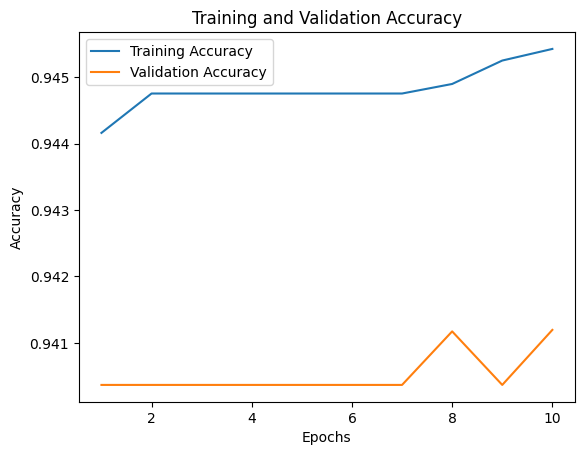

In [ ]:
import matplotlib.pyplot as plt

Acc = history.history["acc"]
val_Acc = history.history["val_acc"]

# Plotting
epochs = range(1, len(Acc) + 1)

plt.plot(epochs, Acc, label="Training Accuracy")
plt.plot(epochs, val_Acc, label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [ ]:
#Clear Keras
tensorflow.keras.backend.clear_session()
gc.collect()

0

In [ ]:
# Train new model
history = model.fit(train_paraghs, train_tags, epochs=10,
                validation_data=(val_paraghs, val_tags), batch_size = 16, verbose=1 #batch_size changed
                #callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=5)]
                    )

Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - acc: 0.9479 - loss: 0.1111 - val_acc: 0.9418 - val_loss: 0.1211
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - acc: 0.9465 - loss: 0.1163 - val_acc: 0.9413 - val_loss: 0.1212
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - acc: 0.9483 - loss: 0.1102 - val_acc: 0.9421 - val_loss: 0.1202
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - acc: 0.9529 - loss: 0.1042 - val_acc: 0.9409 - val_loss: 0.1309
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - acc: 0.9533 - loss: 0.1034 - val_acc: 0.9417 - val_loss: 0.1256
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - acc: 0.9526 - loss: 0.1048 - val_acc: 0.9428 - val_loss: 0.1199
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - acc: 0.9554 - loss: 0.1013 - val_acc: 0.9414 - val_loss: 0.1415
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - acc: 0.9587 - loss: 0.0954 - val_acc: 0.9414 - val_loss: 0.1420
Epoch 9/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - acc: 0.9603 - loss: 

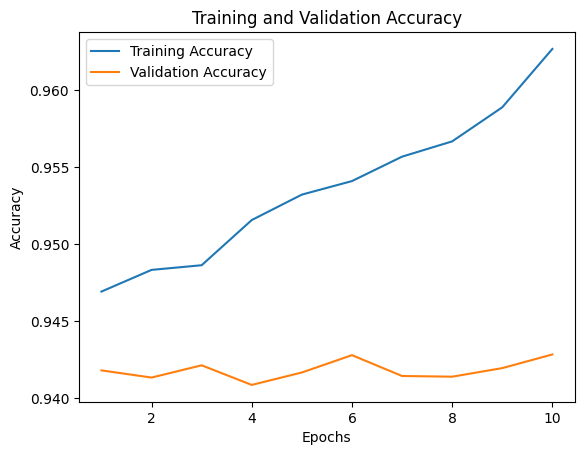

In [ ]:
import matplotlib.pyplot as plt

Acc = history.history["acc"]
val_Acc = history.history["val_acc"]

# Plotting
epochs = range(1, len(Acc) + 1)

plt.plot(epochs, Acc, label="Training Accuracy")
plt.plot(epochs, val_Acc, label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [ ]:
#Clear Keras
tensorflow.keras.backend.clear_session()
gc.collect()

# Train new model
history = model.fit(train_paraghs, train_tags, epochs=10,
                validation_data=(val_paraghs, val_tags), batch_size = 32, verbose=1 #bacth_size changed
                #callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=5)]
                    )

Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 120s 3s/step - acc: 0.7312 - loss: 0.6093 - val_acc: 0.9404 - val_loss: 0.1754
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - acc: 0.9421 - loss: 0.1753 - val_acc: 0.9404 - val_loss: 0.1512
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - acc: 0.9463 - loss: 0.1412 - val_acc: 0.9404 - val_loss: 0.1388
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - acc: 0.9452 - loss: 0.1346 - val_acc: 0.9404 - val_loss: 0.1338
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - acc: 0.9446 - loss: 0.1279 - val_acc: 0.9404 - val_loss: 0.1292
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - acc: 0.9454 - loss: 0.1234 - val_acc: 0.9404 - val_loss: 0.1282
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - acc: 0.9459 - loss: 0.1223 - val_acc: 0.9404 - val_loss: 0.1281
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - acc: 0.9450 - loss: 0.1223 - val_acc: 0.9404 - val_loss: 0.1271
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - acc: 0.9465 - loss:

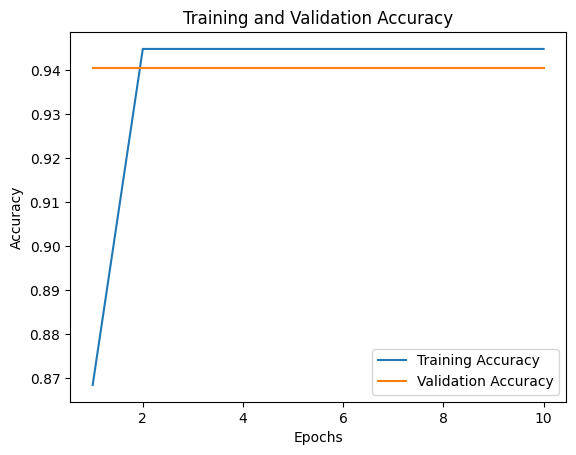

In [ ]:
import matplotlib.pyplot as plt

Acc = history.history["acc"]
val_Acc = history.history["val_acc"]

# Plotting
epochs = range(1, len(Acc) + 1)

plt.plot(epochs, Acc, label="Training Accuracy")
plt.plot(epochs, val_Acc, label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


It seems like batch size 16 is working better.

# Random search

In [ ]:
pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.1 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, TimeDistributed
from tensorflow.keras.optimizers import RMSprop, Adam, Nadam, Adagrad, Adadelta
from tensorflow.keras.losses import CategoricalCrossentropy
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from tensorflow.keras import backend as K
import keras_tuner as kt

We have to define the F1-score as it is not predefined in TensorFlow.

In [ ]:
# Define custom F1 score metric
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [ ]:
#Clear Keras
tensorflow.keras.backend.clear_session()
gc.collect()

0

In [ ]:
def build_model(hp):
    #Input layer
    input_layer = Input(shape=(978,))

    # Calculate the input dimension for embedding
    input_dim = len(list(set(df_clean['Lemma'].to_list())))+1

    # Embedding layer
    embedding = Embedding(
        input_dim=input_dim,
        output_dim=hp.Int('embedding_output_dim', min_value=16, max_value=64, step=16)
    )(input_layer)

    # LSTM layers
    lstm_units = hp.Int('lstm_units', min_value=8, max_value=64, step=16)

    Lstm_1 = LSTM(units=lstm_units, return_sequences=True)(embedding)
    Lstm_2 = LSTM(units=lstm_units, return_sequences=True)(Lstm_1)

    # Output
    output = TimeDistributed(Dense(units=len(id_TO_tag), activation='softmax'))(Lstm_2)

    model = Model(inputs=input_layer, outputs=output)

    # Choose optimizer and learning rate
    optimizer_choice = hp.Choice('optimizer', ['Adam', 'RMSprop', 'Nadam', 'Adagrad', 'Adadelta'])
    learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')

    if optimizer_choice == 'Adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'RMSprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    elif optimizer_choice == 'Nadam':
        optimizer = Nadam(learning_rate=learning_rate)
    elif optimizer_choice == 'Adagrad':
        optimizer = Adagrad(learning_rate=learning_rate)
    else:
        optimizer = Adadelta(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=[f1_m])

    return model

In [ ]:
# Define the objective
objective = kt.Objective("val_f1_m", direction="max")

random_search_tuner = kt.RandomSearch(
    build_model, objective=objective, max_trials=20,
    directory=(r"/content/drive/MyDrive/Final Project/Field Project/NER - IOB"), project_name="LSTM_random_sequence", seed=42)

Reloading Tuner from /content/drive/MyDrive/Final Project/Field Project/NER - IOB/LSTM_random_sequence/tuner0.json


In [ ]:
validation_data = (val_paraghs, val_tags) #Validation set

In [ ]:
random_search_tuner.search(train_paraghs, train_tags, epochs=10,
                           validation_data=validation_data, batch_size = 16, verbose=1,
                           callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_f1_m', mode='max', patience=3)])



Trial 20 Complete [00h 13m 44s]
val_f1_m: 0.9418447017669678

Best val_f1_m So Far: 0.9419081807136536
Total elapsed time: 02h 10m 13s


Epoch 1/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - f1_m: 0.9290 - loss: 0.2910 - val_f1_m: 0.9419 - val_loss: 0.1601
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - f1_m: 0.9435 - loss: 0.1506 - val_f1_m: 0.9420 - val_loss: 0.1459
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - f1_m: 0.9443 - loss: 0.1368 - val_f1_m: 0.9419 - val_loss: 0.1378
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - f1_m: 0.9402 - loss: 0.1376 - val_f1_m: 0.9419 - val_loss: 0.1326
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - f1_m: 0.9475 - loss: 0.1193 - val_f1_m: 0.9419 - val_loss: 0.1303
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - f1_m: 0.9460 - loss: 0.1201 - val_f1_m: 0.9419 - val_loss: 0.1286
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - f1_m: 0.9421 - loss: 0.1256 - val_f1_m: 0.9418 - val_loss: 0.1287
Epoch 8/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - f1_m: 0.9448 - loss: 0.1208 - val_f1_m: 0.9419 - val_loss: 0.1275
Epoch 9/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - f1_

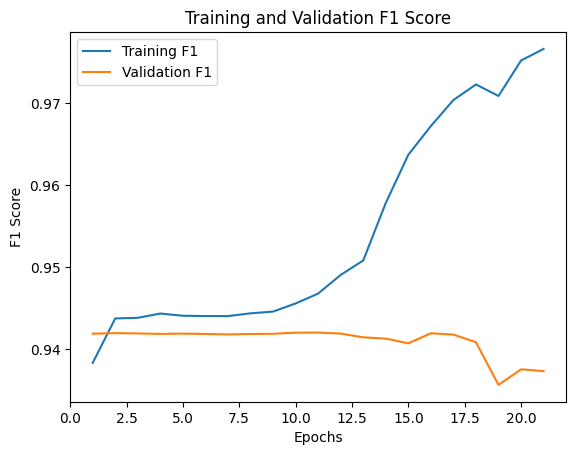

In [ ]:
import matplotlib.pyplot as plt

random_search_result = random_search_tuner.get_best_models(num_models=1)[0]

# Train the best model
history = random_search_result.fit(train_paraghs, train_tags, epochs=30,
                validation_data=validation_data, batch_size = 16, verbose=1,
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_f1_m', mode='max', patience=10)])

f1 = history.history["f1_m"]
val_f1 = history.history["val_f1_m"]

# Plotting
epochs = range(1, len(f1) + 1)

plt.plot(epochs, f1, label="Training F1")
plt.plot(epochs, val_f1, label="Validation F1")
plt.title("Training and Validation F1 Score")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.legend()
plt.show()

In [ ]:
#Save the model
random_search_result.save(r"/content/drive/MyDrive/Final Project/Field Project/NER - IOB/Randoms_search_1.h5")

In [ ]:
#Test set
Paragh_list_test = test_data['Lemma_id'].to_list()
Tag_list_test = test_data['tag_id'].to_list()

In [ ]:
#Padding
from tensorflow.keras.preprocessing.sequence import pad_sequences

pad_paraghs_test = pad_sequences(Paragh_list_test, maxlen= max_lenght, padding='post', value= lemma_TO_id['the'])

pad_tag_test = pad_sequences(Tag_list_test, maxlen=max_lenght_tag, padding='post', value=tag_TO_id['O'])


num_classes = len(tag_TO_id)
pad_tag_test = to_categorical(pad_tag_test, num_classes=num_classes)



In [ ]:
test_paraghs = pad_paraghs_test
test_tags = pad_tag_test


In [ ]:
# Check test set shape
print ('string shape:',test_paraghs.shape)
print ('tag shape:',test_tags.shape)

string shape: (195, 978)
tag shape: (195, 978, 3)


In [ ]:
# Prediction
predicted_tags_test = random_search_result.predict(pad_paraghs_test)

predicted_tag_indices = np.argmax(predicted_tags_test, axis=-1)
true_tag_indices = np.argmax(pad_tag_test, axis=-1)

predicted_tag_indices_flat = predicted_tag_indices.flatten()
true_tag_indices_flat = true_tag_indices.flatten()

#calculate F1-score & accuracy
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix

f1 = f1_score(true_tag_indices_flat, predicted_tag_indices_flat, average='weighted')
accuracy = accuracy_score(true_tag_indices_flat, predicted_tag_indices_flat)

print(f"Test F1 Score: {f1:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

#classification report
print("Classification Report:")
print(classification_report(true_tag_indices_flat, predicted_tag_indices_flat, target_names=list(tag_TO_id.keys())))

# Confusion matrix
conf_matrix = confusion_matrix(true_tag_indices_flat, predicted_tag_indices_flat)
print ("Confusion Matrix:")
print(conf_matrix)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step
Test F1 Score: 0.9294
Test Accuracy: 0.9359
Classification Report:
              precision    recall  f1-score   support

           B       0.00      0.00      0.00       986
           O       0.96      0.98      0.97    180117
           I       0.37      0.28      0.32      9607

    accuracy                           0.94    190710
   macro avg       0.44      0.42      0.43    190710
weighted avg       0.92      0.94      0.93    190710

Confusion Matrix:
[[     0    756    230]
 [     0 175784   4333]
 [     0   6903   2704]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Although the F1-score is high, the model did not learn the "B" class which was the smallest class.

## All features (Lemma+POS+Dependency pars)
In this section, we will use part of speech and dependency parser tags in addition to the lemmatized version of the word for our LSTM model.

In [2]:
#Import dataset
import pandas as pd
df_clean = pd.read_csv(r"/content/drive/MyDrive/Final Project/Field Project/NER - IOB/POS_lemma_DepPars_noTypo_inplaced.csv")

In [3]:
df_clean.head()

,Unnamed: 0,word,tag,Paragraph_place,POS,Lemma,Dependency_pars
0,0,Rydberg,B,A Rydberg 1,PROPN,Rydberg,compound
1,1,atomic,I,A Rydberg 1,ADJ,atomic,amod
2,2,sensors,I,A Rydberg 1,NOUN,sensor,nsubj
3,3,and,I,A Rydberg 1,CCONJ,and,cc
4,4,receivers,I,A Rydberg 1,NOUN,receiver,conj


In [4]:
#Lowercase all the instances
df_clean['POS'] = df_clean['POS'].str.lower()
df_clean['Lemma'] = df_clean['Lemma'].str.lower()
df_clean['Dependency_pars'] = df_clean['Dependency_pars'].str.lower()

In [6]:
from itertools import chain

# Mapping between tokens and their corresponding IDs
def dict_map(data, word_tags):
    token_TO_id = {}
    id_TO_token = {}

    for word_tag in word_tags:
        if word_tag in data.columns:
            vocab = list(set(data[word_tag].to_list()))

            #Mapping dictionaries for each column
            id_TO_token[word_tag] = {id: tok for id, tok in enumerate(vocab)}
            token_TO_id[word_tag] = {tok: id for id, tok in enumerate(vocab)}

    return token_TO_id, id_TO_token


In [7]:
columns_to_map = ['Lemma', 'POS', 'Dependency_pars', 'tag']
token_TO_id, id_TO_token = dict_map(df_clean, columns_to_map)

In [8]:
df = df_clean.copy()

#Apply mapping to the data
df['Lemma_id'] = df['Lemma'].map(token_TO_id['Lemma'])
df['POS_id'] = df['POS'].map(token_TO_id['POS'])
df['Dependency_pars_id'] = df['Dependency_pars'].map(token_TO_id['Dependency_pars'])
df['tag_id'] = df['tag'].map(token_TO_id['tag'])

In [9]:
df.head()

,Unnamed: 0,word,tag,Paragraph_place,POS,Lemma,Dependency_pars,Lemma_id,POS_id,Dependency_pars_id,tag_id
0,0,Rydberg,B,A Rydberg 1,propn,rydberg,compound,5854,3,27,0
1,1,atomic,I,A Rydberg 1,adj,atomic,amod,4373,8,21,2
2,2,sensors,I,A Rydberg 1,noun,sensor,nsubj,2025,1,3,2
3,3,and,I,A Rydberg 1,cconj,and,cc,245,5,4,2
4,4,receivers,I,A Rydberg 1,noun,receiver,conj,3648,1,9,2


In [10]:
#Group by predefined column as mark and aggregate the columns
df_grouped = df.groupby(['Paragraph_place'], as_index=False)[['Lemma', 'tag', 'POS', 'Dependency_pars', 'Lemma_id', 'tag_id', 'POS_id', 'Dependency_pars_id']].agg(lambda x: list(x))

In [11]:
df_grouped.head()

,Paragraph_place,Lemma,tag,POS,Dependency_pars,Lemma_id,tag_id,POS_id,Dependency_pars_id
0,A Rydberg 1,"[rydberg, atomic, sensor, and, receiver, have,...","[B, I, I, I, I, I, I, I, I, I, I, I, I, I, I, ...","[propn, adj, noun, cconj, noun, aux, verb, adj...","[compound, amod, nsubj, cc, conj, aux, root, a...","[5854, 4373, 2025, 245, 3648, 409, 1883, 4991,...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[3, 8, 1, 5, 1, 0, 6, 8, 5, 8, 1, 11, 3, 1, 11...","[27, 21, 3, 4, 9, 14, 29, 21, 4, 9, 16, 8, 27,..."
1,A Rydberg 10,"[the, automotive, radar, chip, present, as, th...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[det, adj, noun, noun, verb, adp, det, noun, a...","[det, amod, compound, nsubj, root, prep, det, ...","[951, 1225, 2324, 3292, 7530, 617, 951, 1795, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[14, 8, 1, 1, 6, 11, 14, 1, 11, 1, 11, 14, 1, ...","[11, 21, 27, 3, 29, 8, 11, 26, 8, 26, 8, 11, 2..."
2,A Rydberg 11,"[for, the, demonstration, of, the, benchmarke,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[adp, det, noun, adp, det, noun, noun, punct, ...","[prep, det, pobj, prep, det, amod, pobj, punct...","[3744, 951, 6695, 4940, 951, 2813, 6752, 5513,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[11, 14, 1, 11, 14, 1, 1, 7, 16, 4, 6, 14, 8, ...","[8, 11, 26, 8, 11, 21, 26, 18, 3, 10, 29, 11, ..."
3,A Rydberg 12,"[next, ,, we, use, the, setup, to, estimate, t...","[O, O, B, I, I, I, I, I, I, I, I, I, I, I, I, ...","[adv, punct, pron, verb, det, noun, adp, verb,...","[advmod, punct, nsubj, root, det, pobj, prep, ...","[2815, 5513, 507, 2920, 951, 6752, 21, 7310, 9...","[1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[4, 7, 16, 6, 14, 1, 11, 6, 14, 8, 1, 11, 14, ...","[10, 18, 3, 29, 11, 26, 8, 1, 11, 21, 16, 8, 1..."
4,A Rydberg 13,"[consequently, ,, we, demonstrate, that, use, ...","[O, O, B, I, I, I, I, I, O, I, I, I, I, I, I, ...","[adv, punct, pron, verb, sconj, verb, det, nou...","[advmod, punct, nsubj, root, nsubjpass, advcl,...","[4608, 5513, 507, 823, 6745, 2920, 6422, 6752,...","[1, 1, 0, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, ...","[4, 7, 16, 6, 9, 6, 14, 1, 7, 14, 1, 11, 3, 1,...","[10, 18, 3, 29, 17, 1, 11, 16, 18, 11, 26, 8, ..."


In [12]:
from sklearn.model_selection import train_test_split

grouped = df_grouped.groupby('Paragraph_place')

sizes = grouped.size().cumsum() #cumulative size

train_size = 0.7 * sizes.iloc[-1]
val_size = 0.2 * train_size
test_size = sizes.iloc[-1] - train_size

#Train, test index based on 'Paragraph_place' column
train_idx = sizes[sizes <= train_size].index
test_idx = sizes[sizes > train_size].index


train_data_with_val = df_grouped[df_grouped['Paragraph_place'].isin(train_idx)]
test_data = df_grouped[df_grouped['Paragraph_place'].isin(test_idx)]

#Validation set
train_sizes = train_data_with_val.groupby('Paragraph_place').size().cumsum()
val_idx = train_sizes[train_sizes <= val_size].index
final_train_idx = train_sizes[train_sizes > val_size].index

val_data = train_data_with_val[train_data_with_val['Paragraph_place'].isin(val_idx)]
train_data = train_data_with_val[train_data_with_val['Paragraph_place'].isin(final_train_idx)]

In [14]:
#Maximum Paragh length
Paragh_list_lemma = train_data['Lemma_id'].to_list()
Paragh_list_POS = train_data['POS_id'].to_list()
Paragh_list_Dep_Pars = train_data['Dependency_pars_id'].to_list()

max_lenght = max([len(paragh) for paragh in Paragh_list_lemma])
print("max length is %i" %max_lenght)

#Maximum Tag length
Tag_list = train_data['tag_id'].to_list()
max_lenght_tag = max([len(tag) for tag in Tag_list])

max length is 978


In [15]:
#Padding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

pad_paraghs_lemma = pad_sequences(Paragh_list_lemma, maxlen= max_lenght, padding='post', value= token_TO_id['Lemma']['the'])
pad_paraghs_POS = pad_sequences(Paragh_list_POS, maxlen= max_lenght, padding='post', value= token_TO_id['POS']['det'])
pad_paraghs_Dep_Pars = pad_sequences(Paragh_list_Dep_Pars, maxlen= max_lenght, padding='post', value= token_TO_id['Dependency_pars']['det'])

pad_tags = pad_sequences(Tag_list, maxlen=max_lenght_tag, padding='post', value=token_TO_id['tag']['O'])


# Determine number of classes
num_classes = len(token_TO_id['tag'])
pad_tags = to_categorical(pad_tags, num_classes=num_classes)

In [17]:
import numpy as np

#Combine all features to a 3D tensor
combined_inputs = np.stack((pad_paraghs_lemma, pad_paraghs_POS, pad_paraghs_Dep_Pars), axis=1)

In [18]:
combined_inputs

array([[[7030,  507,  479, ...,  951,  951,  951],
        [   4,   16,    6, ...,   14,   14,   14],
        [  10,    3,   29, ...,   11,   11,   11]],

       [[4882, 4830, 3305, ...,  951,  951,  951],
        [  16,    1,    6, ...,   14,   14,   14],
        [  24,    3,   29, ...,   11,   11,   11]],

       [[4052, 1948, 1629, ...,  951,  951,  951],
        [   8,    1,   11, ...,   14,   14,   14],
        [  21,   17,    8, ...,   11,   11,   11]],

       ...,

       [[2869, 2446, 4940, ...,  951,  951,  951],
        [  14,    1,   11, ...,   14,   14,   14],
        [  11,   17,    8, ...,   11,   11,   11]],

       [[4684,    6, 3199, ...,  951,  951,  951],
        [  14,    8,    8, ...,   14,   14,   14],
        [  11,   21,   21, ...,   11,   11,   11]],

       [[4182,  409, 5812, ...,  951,  951,  951],
        [   3,    0,    0, ...,   14,   14,   14],
        [   3,   14,   29, ...,   11,   11,   11]]], dtype=int32)

In [19]:
#Transpose to make the shape same as labels
combined_inputs = combined_inputs.transpose(0, 2, 1)


In [20]:
train_paraghs = combined_inputs
print ('Train shape:',train_paraghs.shape)

train_tags = pad_tags
print ('tag shape:',train_tags.shape)

Train shape: (362, 978, 3)
tag shape: (362, 978, 3)


In [21]:
import numpy as np
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, TimeDistributed, Dense
from tensorflow.keras.utils import plot_model
import tensorflow
import gc

In [ ]:
input_shape = (978, 3)
output_nodes = 3 #As we have 3 classes I, O and B
output_dim = 32


In [ ]:
# Clear Keras session
tensorflow.keras.backend.clear_session()
gc.collect()

# Model definition
input_layer = Input(shape=input_shape)
Lstm_1 = LSTM(units=output_dim, return_sequences=True)(input_layer)
Lstm_2 = LSTM(units=output_dim, return_sequences=True)(Lstm_1)
output = TimeDistributed(Dense(units=output_nodes, activation='softmax'))(Lstm_2)

model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer=tensorflow.keras.optimizers.RMSprop(1e-3),
              loss=tensorflow.keras.losses.CategoricalCrossentropy(),
              metrics=['acc'])



In [ ]:
# Summary of the model
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 978, 3)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 978, 32)             │           4,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 978, 32)             │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 978, 3)              │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,027 (50.89 KB)

 Trainable params: 13,027 (50.89 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Validation set

validation_lemma = val_data['Lemma_id'].to_list()
validation_POS = val_data['POS_id'].to_list()
validation_Dep_Pars = val_data['Dependency_pars_id'].to_list()

validation_Tag_list = val_data['tag_id'].to_list()


val_pad_paraghs_lemma = pad_sequences(validation_lemma, maxlen= max_lenght, padding='post', value= token_TO_id['Lemma']['the'])
val_pad_paraghs_POS = pad_sequences(validation_POS, maxlen= max_lenght, padding='post', value= token_TO_id['POS']['det'])
val_pad_paraghs_Dep_Pars = pad_sequences(validation_Dep_Pars, maxlen= max_lenght, padding='post', value= token_TO_id['Dependency_pars']['det'])

val_pad_tags = pad_sequences(validation_Tag_list, maxlen=max_lenght, padding='post', value=token_TO_id['tag']['O'])


# Determine number of classes
num_classes = len(token_TO_id['tag'])
val_pad_tags = to_categorical(val_pad_tags, num_classes=num_classes)

In [23]:
val_combined_inputs = np.stack((val_pad_paraghs_lemma, val_pad_paraghs_POS, val_pad_paraghs_Dep_Pars), axis=1)

val_combined_inputs = val_combined_inputs.transpose(0, 2, 1)

In [24]:
val_paraghs = combined_inputs
print ('validation shape:',val_paraghs.shape)

val_tags = pad_tags
print ('validation tag shape:',val_tags.shape)

validation shape: (362, 978, 3)
validation tag shape: (362, 978, 3)


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, TimeDistributed, Dense
import matplotlib.pyplot as plt
import gc

# Model function based on accuracy to check further for diffrent batch sizes
def train_model_with_batch_size(batch_size):
    tensorflow.keras.backend.clear_session()
    gc.collect()

    input_shape = (978, 3)
    output_nodes = 3
    output_dim = 32

    # Model architecture
    input_layer = Input(shape=input_shape)
    Lstm_1 = LSTM(units=output_dim, return_sequences=True)(input_layer)
    Lstm_2 = LSTM(units=output_dim, return_sequences=True)(Lstm_1)
    output = TimeDistributed(Dense(units=output_nodes, activation='softmax'))(Lstm_2)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer=tf.keras.optimizers.RMSprop(1e-3),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['acc'])

    # Training
    history = model.fit(train_paraghs, train_tags, epochs=10,
                        validation_data=(val_paraghs, val_tags),
                        batch_size=batch_size, verbose=1)

    return history


Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - acc: 0.9432 - loss: 0.3815 - val_acc: 0.9403 - val_loss: 0.1495
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - acc: 0.9432 - loss: 0.1430 - val_acc: 0.9448 - val_loss: 0.1281
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - acc: 0.9416 - loss: 0.1346 - val_acc: 0.9448 - val_loss: 0.1404
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - acc: 0.9462 - loss: 0.1228 - val_acc: 0.9266 - val_loss: 0.1343
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - acc: 0.9420 - loss: 0.1276 - val_acc: 0.9447 - val_loss: 0.1261
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - acc: 0.9432 - loss: 0.1409 - val_acc: 0.9448 - val_loss: 0.1241
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - acc: 0.9444 - loss: 0.1275 - val_acc: 0.9448 - val_loss: 0.1226
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - acc: 0.9421 - loss: 0.1307 - val_acc: 0.9448 - val_loss: 0.1225
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - acc: 0.9422 - loss:

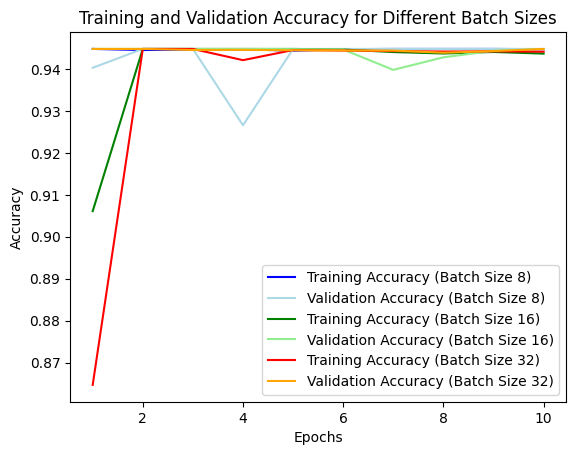

In [ ]:
#Training model with different batch sizes
history_8 = train_model_with_batch_size(8)
history_16 = train_model_with_batch_size(16)
history_32 = train_model_with_batch_size(32)

# Plotting
epochs = range(1, 11)

plt.plot(epochs, history_8.history['acc'], label="Training Accuracy (Batch Size 8)", color='blue')
plt.plot(epochs, history_8.history['val_acc'], label="Validation Accuracy (Batch Size 8)", color='lightblue')

plt.plot(epochs, history_16.history['acc'], label="Training Accuracy (Batch Size 16)", color='green')
plt.plot(epochs, history_16.history['val_acc'], label="Validation Accuracy (Batch Size 16)", color='lightgreen')

plt.plot(epochs, history_32.history['acc'], label="Training Accuracy (Batch Size 32)", color='red')
plt.plot(epochs, history_32.history['val_acc'], label="Validation Accuracy (Batch Size 32)", color='orange')

plt.title("Training and Validation Accuracy for Different Batch Sizes")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


## Random serach on all features

In [25]:
pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.1 MB/s eta 0:00:00


In [26]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, TimeDistributed
from tensorflow.keras.optimizers import RMSprop, Adam, Nadam, Adagrad, Adadelta
from tensorflow.keras.losses import CategoricalCrossentropy
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from tensorflow.keras import backend as K
import keras_tuner as kt

In [27]:
# Define custom F1 score metric
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In the next cell, we also added L2 regularization to avoid the overfitting problems that happened in the previous attempt on the lemmatized version of the word.

In [28]:
import keras_tuner as kt
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam, RMSprop, Nadam, Adagrad, Adadelta
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2

def build_model(hp):

    input_layer = Input(shape=(978, 3))

    # L2 regularization
    l2_reg = hp.Float('l2_regularization', min_value=1e-5, max_value=1e-1, sampling='log')

    # LSTM layers + L2
    lstm_units = hp.Int('lstm_units', min_value=8, max_value=64, step=16)

    Lstm_1 = LSTM(units=lstm_units, return_sequences=True,
                  kernel_regularizer=l2(l2_reg))(input_layer)
    Lstm_2 = LSTM(units=lstm_units, return_sequences=True,
                  kernel_regularizer=l2(l2_reg))(Lstm_1)

    # Output layer
    output = TimeDistributed(Dense(units=3, activation='softmax'))(Lstm_2)

    model = Model(inputs=input_layer, outputs=output)

    #optimizers and learning rates
    optimizer_choice = hp.Choice('optimizer', ['Adam', 'RMSprop', 'Nadam', 'Adagrad', 'Adadelta'])
    learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')

    if optimizer_choice == 'Adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'RMSprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    elif optimizer_choice == 'Nadam':
        optimizer = Nadam(learning_rate=learning_rate)
    elif optimizer_choice == 'Adagrad':
        optimizer = Adagrad(learning_rate=learning_rate)
    else:
        optimizer = Adadelta(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=[f1_m])

    return model

In [29]:
# Define the objective
objective = kt.Objective("val_f1_m", direction="max")

random_search_tuner = kt.RandomSearch(
    build_model, objective=objective, max_trials=20,
    directory=(r"/content/drive/MyDrive/Final Project/Field Project/NER - IOB"),
    project_name="LSTM_Allfeature_random_sequence", seed=42)


In [30]:
validation_data = (val_paraghs, val_tags) #Validation set

In [31]:
random_search_tuner.search(train_paraghs, train_tags, epochs=10,
                           validation_data=validation_data, batch_size = 16, verbose=1,
                           callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_f1_m', mode='max', patience=3)])



Trial 20 Complete [00h 01m 34s]
val_f1_m: 0.9439899325370789

Best val_f1_m So Far: 0.9442136287689209
Total elapsed time: 00h 31m 18s


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


23/23 ━━━━━━━━━━━━━━━━━━━━ 62s 632ms/step - f1_m: 0.9460 - loss: 0.3994 - val_f1_m: 0.9441 - val_loss: 0.3653
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 212ms/step - f1_m: 0.9435 - loss: 0.3598 - val_f1_m: 0.9441 - val_loss: 0.3327
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 209ms/step - f1_m: 0.9476 - loss: 0.3191 - val_f1_m: 0.9438 - val_loss: 0.3057
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 208ms/step - f1_m: 0.9446 - loss: 0.2958 - val_f1_m: 0.9436 - val_loss: 0.2753
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 210ms/step - f1_m: 0.9418 - loss: 0.2831 - val_f1_m: 0.9420 - val_loss: 0.2602
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 206ms/step - f1_m: 0.9457 - loss: 0.2473 - val_f1_m: 0.9435 - val_loss: 0.2326
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 207ms/step - f1_m: 0.9442 - loss: 0.2399 - val_f1_m: 0.9426 - val_loss: 0.2214
Epoch 8/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 209ms/step - f1_m: 0.9460 - loss: 0.2275 - val_f1_m: 0.9432 - val_loss: 0.2304
Epoch 9/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 205ms/ste

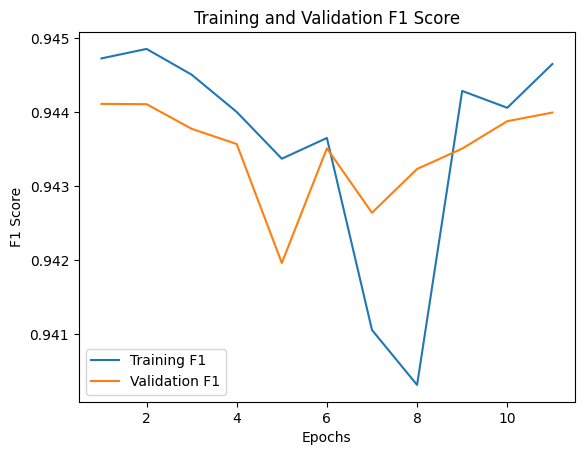

In [32]:
import matplotlib.pyplot as plt

random_search_result = random_search_tuner.get_best_models(num_models=1)[0]

# Train the best model
history = random_search_result.fit(train_paraghs, train_tags, epochs=30,
                validation_data=validation_data, batch_size = 16, verbose=1,
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_f1_m', mode='max', patience=10)])

f1 = history.history["f1_m"]
val_f1 = history.history["val_f1_m"]

# Plotting
epochs = range(1, len(f1) + 1)

plt.plot(epochs, f1, label="Training F1")
plt.plot(epochs, val_f1, label="Validation F1")
plt.title("Training and Validation F1 Score")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.legend()
plt.show()

In [33]:
#Save the model
random_search_result.save(r"/content/drive/MyDrive/Final Project/Field Project/NER - IOB/Randoms_search_allfeatures_1.h5")

In [34]:
# Test set

test_lemma = test_data['Lemma_id'].to_list()
test_POS = test_data['POS_id'].to_list()
test_Dep_Pars = test_data['Dependency_pars_id'].to_list()

test_Tag_list = test_data['tag_id'].to_list()


test_pad_paraghs_lemma = pad_sequences(test_lemma, maxlen= max_lenght, padding='post', value= token_TO_id['Lemma']['the'])
test_pad_paraghs_POS = pad_sequences(test_POS, maxlen= max_lenght, padding='post', value= token_TO_id['POS']['det'])
test_pad_paraghs_Dep_Pars = pad_sequences(test_Dep_Pars, maxlen= max_lenght, padding='post', value= token_TO_id['Dependency_pars']['det'])

test_pad_tags = pad_sequences(test_Tag_list, maxlen=max_lenght, padding='post', value=token_TO_id['tag']['O'])


# Determine number of classes
num_classes = len(token_TO_id['tag'])
test_pad_tags = to_categorical(test_pad_tags, num_classes=num_classes)

test_combined_inputs = np.stack((test_pad_paraghs_lemma, test_pad_paraghs_POS, test_pad_paraghs_Dep_Pars), axis=1)

test_combined_inputs = test_combined_inputs.transpose(0, 2, 1)

In [35]:
test_paraghs = test_combined_inputs
test_tags = test_pad_tags

In [38]:
# Prediction
predicted_tags_test = random_search_result.predict(test_paraghs)

predicted_tag_indices = np.argmax(predicted_tags_test, axis=-1)
true_tag_indices = np.argmax(test_tags, axis=-1)

predicted_tag_indices_flat = predicted_tag_indices.flatten()
true_tag_indices_flat = true_tag_indices.flatten()

#calculate F1-score & accuracy
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix

f1 = f1_score(true_tag_indices_flat, predicted_tag_indices_flat, average='weighted')
accuracy = accuracy_score(true_tag_indices_flat, predicted_tag_indices_flat)

print(f"Test F1 Score: {f1:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

#classification report
print("Classification Report:")
print(classification_report(true_tag_indices_flat, predicted_tag_indices_flat))#, target_names=list(token_TO_id.keys())))

# Confusion matrix
conf_matrix = confusion_matrix(true_tag_indices_flat, predicted_tag_indices_flat)
print ("Confusion Matrix:")
print(conf_matrix)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Test F1 Score: 0.9175
Test Accuracy: 0.9445
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       986
           1       0.94      1.00      0.97    180117
           2       0.00      0.00      0.00      9607

    accuracy                           0.94    190710
   macro avg       0.31      0.33      0.32    190710
weighted avg       0.89      0.94      0.92    190710

Confusion Matrix:
[[     0    986      0]
 [     0 180117      0]
 [     0   9607      0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Same as before, the model did not learn and labelled every instance with the bigger class.

In [39]:
!pip freeze > requirements.txt